In [1]:
!apt-get update && apt-get install -y libgl1
!pip install opencv-python-headless
!pip install numpy pandas matplotlib decord scipy pillow
!pip install moviepy==1.0.3
!pip install seaborn

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1 is already the newest version (1.4.0-1).
0 upgraded, 0 newly installed, 0 to remove and 128 not upgraded.


In [2]:
!pip install openpyxl

In [3]:

import os
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from decord import VideoReader, cpu
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight


warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"


input_size = 224
num_frame = 16
batch_size = 10
initial_learning_rate = 1.5e-4
min_learning_rate = 1e-6
epochs = 50


base_dir = '/home/jovyan/onmixed-data-last'
train_dir = os.path.join(base_dir, 'MAFW_FSLF_split/train')
val_dir = os.path.join(base_dir, 'MAFW_FSLF_split/val')
test_dir = os.path.join(base_dir, 'MAFW_FSLF_split/test')
metadata_path = os.path.join(base_dir, "emotion_metadata_removed_specific.xlsx")
model_path = os.path.join(base_dir, "model")


EMOTIONS = ['anger', 'happiness', 'disgust', 'fear', 'sadness']

# Enable GPU acceleration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()


metadata = pd.read_excel(metadata_path, engine='openpyxl')


split_mapping = {}
for split, dir_path in [('train', train_dir), ('val', val_dir), ('test', test_dir)]:
    for emotion in EMOTIONS:
        emotion_dir = os.path.join(dir_path, emotion)
        if os.path.exists(emotion_dir):  # Only process existing emotion directories
            for filename in os.listdir(emotion_dir):
                if filename.endswith(('.mp4', '.avi', '.mov')):
                    split_mapping[filename] = split


metadata['split'] = metadata['expected_filename'].map(split_mapping)
metadata = metadata.dropna(subset=['split'])  


def get_full_path(row):
    filename = row['expected_filename']
    split = row['split']
    emotion = row['dominant_emotion'].lower()  
    
    if split == 'train':
        return os.path.join(train_dir, emotion, filename)
    elif split == 'val':
        return os.path.join(val_dir, emotion, filename)
    elif split == 'test':
        return os.path.join(test_dir, emotion, filename)
    else:
        raise ValueError(f"Unknown split: {split}")

metadata['video_path'] = metadata.apply(lambda row: get_full_path(row), axis=1)


label_encoder = LabelEncoder()
metadata['emotion_label'] = label_encoder.fit_transform(metadata['dominant_emotion'])
num_classes = len(label_encoder.classes_)
print(f"Emotion classes: {label_encoder.classes_}")


def is_video_valid(fpath):
    if not os.path.exists(fpath):
        print(f"❌ File not found: {fpath}")
        return False
    try:
        vr = VideoReader(fpath, ctx=cpu(0))
        if len(vr) < num_frame:
            print(f"❌ Too short: {fpath} (has {len(vr)} frames, needs {num_frame})")
            return False
       
        vr.get_batch([0]).asnumpy()
        return True
    except Exception as e:
        print(f"❌ Corrupted: {fpath} - Error: {str(e)}")
        return False

valid_mask = metadata['video_path'].apply(is_video_valid)
df = metadata[valid_mask].copy()

print(f"\nLoaded {len(df)} valid samples")
print("Target ranges:")
print(f"Valence: {df['Adjusted Valence'].min():.2f} to {df['Adjusted Valence'].max():.2f}")
print(f"Arousal: {df['Adjusted Arousal'].min():.2f} to {df['Adjusted Arousal'].max():.2f}")
print("\nEmotion distribution:")
print(df['dominant_emotion'].value_counts())


train_df = df[df['split'] == 'train']
val_df = df[df['split'] == 'val']
test_df = df[df['split'] == 'test']

print(f"\nSplit sizes - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")



def read_video(path):
    path = path.numpy().decode('utf-8')
    try:
        vr = VideoReader(path, ctx=cpu(0))
        total = len(vr)
        
        if tf.random.uniform(()) > 0.5:  # Random temporal sampling
            start = tf.random.uniform((), 0, max(1, total - num_frame), dtype=tf.int32)
            idx = tf.range(start, start + num_frame)
        else:  # Uniform sampling
            idx = np.linspace(0, total - 1, num_frame, dtype=np.int32)
        
        idx = np.clip(idx, 0, total - 1)
        frames = vr.get_batch(idx).asnumpy()
        frames = tf.image.convert_image_dtype(frames, tf.float32)
        frames = tf.image.resize(frames, [input_size, input_size])
        
        # Data augmentation
        if tf.random.uniform(()) > 0.5:
            frames = tf.image.flip_left_right(frames)
        
        frames = tf.image.random_brightness(frames, max_delta=0.1)
        return frames
    except Exception as e:
        print(f"Error reading {path}: {str(e)}")
        return tf.zeros([num_frame, input_size, input_size, 3], dtype=tf.float32)

def load_video(path, targets):
    vid = tf.py_function(read_video, inp=[path], Tout=tf.float32)
    vid.set_shape([num_frame, input_size, input_size, 3])
    
    va_targets = tf.cast(targets[:2], tf.float32)
    emotion_target = tf.cast(targets[2], tf.int32)
    
    return vid, {
        'valence': va_targets[0],
        'arousal': va_targets[1],
        'emotion': emotion_target
    }


def create_ds(df, shuffle=True):
    paths = df['video_path'].values
    va_targets = df[['Adjusted Valence', 'Adjusted Arousal']].values.astype(np.float32)
    emotion_targets = df['emotion_label'].values
    targets = np.column_stack([va_targets, emotion_targets])
    
    ds = tf.data.Dataset.from_tensor_slices((paths, targets))
    if shuffle:
        ds = ds.shuffle(len(paths), reshuffle_each_iteration=True)
    
    ds = ds.map(
        lambda p, t: load_video(p, t),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


train_ds = create_ds(train_df, shuffle=True)
val_ds = create_ds(val_df, shuffle=False)
test_ds = create_ds(test_df, shuffle=False)


class TFSMLayer(layers.Layer):
    def __init__(self, model_path, **kwargs):
        super().__init__(**kwargs)
        self.model_path = model_path
        self.model = tf.saved_model.load(model_path)
        self.signatures = list(self.model.signatures.keys())
        
        
        self.default_sig = self.model.signatures.get('serving_default', self.model.signatures[self.signatures[0]])
        
    def call(self, inputs):
        
        inputs = tf.cast(inputs, tf.float32)
        
        
        try:
            outputs = self.default_sig(input_1=inputs)
            return outputs['output_1']
        except Exception as e:
            
            for sig_name in self.signatures:
                try:
                    sig = self.model.signatures[sig_name]
                    outputs = sig(input_1=inputs)
                    return outputs['output_1']
                except:
                    continue
            raise ValueError(f"Could not find compatible signature. Error: {str(e)}")


with strategy.scope():
    inp = layers.Input((num_frame, input_size, input_size, 3))
    
    try:
        pretrained_layer = TFSMLayer(model_path)
        x = pretrained_layer(inp)
        
        
        if len(x.shape) == 2:
            total_features = x.shape[-1]
            features_per_frame = total_features // num_frame
            if total_features % num_frame != 0:
                print(f"Warning: Total features {total_features} not divisible by num_frame {num_frame}")
                features_per_frame = total_features
            
            x = layers.Reshape((num_frame, features_per_frame))(x)
            
    except Exception as e:
        print(f"Error loading pretrained model: {str(e)}")
        print("Using fallback architecture")
        x = layers.TimeDistributed(layers.Conv2D(64, (3,3), activation='relu'))(inp)
        x = layers.TimeDistributed(layers.MaxPooling2D())(x)
        x = layers.TimeDistributed(layers.Conv2D(128, (3,3), activation='relu'))(x)
        x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(x)
    
    
    x = layers.LSTM(256, return_sequences=False)(x)
    
    
    valence_branch = layers.Dense(128, activation='relu')(x)
    valence_branch = layers.Dropout(0.3)(valence_branch)
    valence_out = layers.Dense(1, activation='tanh', name='valence', dtype='float32')(valence_branch)
    
    
    arousal_branch = layers.Dense(128, activation='relu')(x)
    arousal_branch = layers.Dropout(0.3)(arousal_branch)
    arousal_out = layers.Dense(1, activation='tanh', name='arousal', dtype='float32')(arousal_branch)
    
    
    emotion_branch = layers.Dense(256, activation='relu')(x)
    emotion_branch = layers.Dropout(0.5)(emotion_branch)
    emotion_out = layers.Dense(num_classes, activation='softmax', name='emotion', dtype='float32')(emotion_branch)
    
    model = keras.Model(inp, [valence_out, arousal_out, emotion_out], name="multi_task_model")
    
    emotion_labels = train_df['emotion_label'].values
    class_weights = compute_class_weight('balanced', classes=np.unique(emotion_labels), y=emotion_labels)
    emotion_class_weights = dict(enumerate(class_weights))
    
    
    def weighted_sparse_categorical_crossentropy(y_true, y_pred):
        loss = keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        weights = tf.gather(
            tf.constant(list(emotion_class_weights.values()), dtype=tf.float32),
            tf.cast(y_true, tf.int32)
        )
        return loss * weights
    
    
    
    

   
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
       initial_learning_rate,
       decay_steps=len(train_ds)*20,  # زيادة decay_steps
       decay_rate=0.95,
       staircase=True
       )
    
    # AdamW optimizer with weight decay
    optimizer = keras.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay=1e-4,
        beta_1=0.9,
        beta_2=0.999
    )
    
    
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    
   
    model.compile(
        optimizer=optimizer,
        loss={
            'valence': 'mse',
            'arousal': 'mse',
            'emotion': weighted_sparse_categorical_crossentropy
        },
        metrics={
            'valence': ['mae'],
            'arousal': ['mae'],
            'emotion': ['accuracy']
        },
        loss_weights={
            'valence': 1.0,
            'arousal': 1.0,
            'emotion': 3.0
        }
    )

model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=40,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=min_learning_rate,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        save_best_only=True,
        monitor='val_loss',
        save_weights_only=True
    ),
    keras.callbacks.TensorBoard(
        log_dir='./logs',
        histogram_freq=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

print("\nEvaluating on test set...")
test_results = model.evaluate(test_ds, verbose=2)
print("\nTest Results:")
print(f"Valence MAE: {test_results[3]:.4f}")
print(f"Arousal MAE: {test_results[4]:.4f}")
print(f"Emotion Accuracy: {test_results[5]:.4f}")

# 9. Sample predictions
print("\nSample predictions:")
sample_videos = test_df.sample(3)
for idx, row in sample_videos.iterrows():
    frames = read_video(tf.constant(row['video_path']))
    frames = tf.expand_dims(frames, 0)
    v_pred, a_pred, e_pred = model.predict(frames, verbose=0)
    
    pred_emotion_idx = np.argmax(e_pred[0])
    pred_emotion = label_encoder.inverse_transform([pred_emotion_idx])[0]
    
    print(f"\nVideo: {os.path.basename(row['video_path'])}")
    print(f"True Emotion: {row['dominant_emotion']}, Predicted: {pred_emotion}")
    print(f"True Valence: {row['Adjusted Valence']:.4f}, Predicted: {v_pred[0][0]:.4f}")
    print(f"True Arousal: {row['Adjusted Arousal']:.4f}, Predicted: {a_pred[0][0]:.4f}")

2025-06-30 16:05:34.253665: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100-SXM4-40GB MIG 2g.10gb, compute capability 8.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Emotion classes: ['anger' 'disgust' 'fear' 'happiness' 'sadness']


2025-06-30 16:05:36.824742: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7898 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:90:00.0, compute capability: 8.0


❌ Corrupted: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/test/fear/fear_01471.mp4 - Error: [16:05:40] /github/workspace/src/video/video_reader.cc:151: Check failed: st_nb >= 0 (-1381258232 vs. 0) ERROR cannot find video stream with wanted index: -1
❌ Corrupted: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/train/happiness/happiness_01629.mp4 - Error: [16:05:40] /github/workspace/src/video/video_reader.cc:151: Check failed: st_nb >= 0 (-1381258232 vs. 0) ERROR cannot find video stream with wanted index: -1
❌ Corrupted: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/test/sadness/sadness_01788.mp4 - Error: [16:05:40] /github/workspace/src/video/video_reader.cc:151: Check failed: st_nb >= 0 (-1381258232 vs. 0) ERROR cannot find video stream with wanted index: -1
❌ Corrupted: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/train/sadness/sadness_02839.mp4 - Error: [16:05:42] /github/workspace/src/video/video_reader.cc:151: Check failed: st_nb >= 0 (-1381258232 vs. 0) ERROR cannot find vid

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x558d69039140] moov atom not found
[16:05:43] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/val/anger/anger_03810.mp4, Invalid data found when processing input
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x558d68e7fb00] moov atom not found
[16:05:44] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/train/disgust/disgust_08776.mp4, Invalid data found when processing input


❌ Corrupted: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/train/disgust/disgust_08776.mp4 - Error: Error reading /home/jovyan/onmixed-data-last/MAFW_FSLF_split/train/disgust/disgust_08776.mp4...
❌ Corrupted: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/train/disgust/disgust_10135.mp4 - Error: [16:05:45] /github/workspace/src/video/video_reader.cc:151: Check failed: st_nb >= 0 (-1381258232 vs. 0) ERROR cannot find video stream with wanted index: -1
❌ Corrupted: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/train/disgust/disgust_10160.mp4 - Error: Error reading /home/jovyan/onmixed-data-last/MAFW_FSLF_split/train/disgust/disgust_10160.mp4...


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x558d69039140] moov atom not found
[16:05:45] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/train/disgust/disgust_10160.mp4, Invalid data found when processing input


❌ Corrupted: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/train/fear/fear_10575.mp4 - Error: [16:05:45] /github/workspace/src/video/video_reader.cc:151: Check failed: st_nb >= 0 (-1381258232 vs. 0) ERROR cannot find video stream with wanted index: -1

Loaded 1329 valid samples
Target ranges:
Valence: -0.77 to 0.84
Arousal: -0.38 to 0.77

Emotion distribution:
happiness    267
anger        267
disgust      266
fear         265
sadness      264
Name: dominant_emotion, dtype: int64

Split sizes - Train: 928, Val: 199, Test: 202
Model: "multi_task_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 16, 224, 224, 3)]    0         []                            
                                                                                                  
 tfsm_layer (TFSMLayer)      (None, 400)     

2025-06-30 16:05:59.998302: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_DOUBLE
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 928
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
        dim {
          size: 3
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
      

Epoch 1/50
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

2025-06-30 16:06:12.243640: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558dba6d29a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-30 16:06:12.243697: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 2g.10gb, Compute Capability 8.0
2025-06-30 16:06:12.429421: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2025-06-30 16:06:12.740440: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-30 16:06:15.043522: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-30 16:06:32.059044: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'tri

92/93 [============================>.] - ETA: 1s - loss: 5.1923 - valence_loss: 0.2521 - arousal_loss: 0.1349 - emotion_loss: 1.6017 - valence_mae: 0.4007 - arousal_mae: 0.3075 - emotion_accuracy: 0.2380

2025-06-30 16:08:51.800583: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


93/93 [==============================] - ETA: 0s - loss: 5.1919 - valence_loss: 0.2524 - arousal_loss: 0.1342 - emotion_loss: 1.6018 - valence_mae: 0.4011 - arousal_mae: 0.3062 - emotion_accuracy: 0.2371

2025-06-30 16:08:53.251536: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_DOUBLE
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 199
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:5"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
        dim {
          size: 3
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
      

93/93 [==============================] - 215s 2s/step - loss: 5.1919 - valence_loss: 0.2524 - arousal_loss: 0.1342 - emotion_loss: 1.6018 - valence_mae: 0.4011 - arousal_mae: 0.3062 - emotion_accuracy: 0.2371 - val_loss: 5.1347 - val_valence_loss: 0.2384 - val_arousal_loss: 0.1418 - val_emotion_loss: 1.5848 - val_valence_mae: 0.3989 - val_arousal_mae: 0.3225 - val_emotion_accuracy: 0.2915 - lr: 1.5000e-04
Epoch 2/50
92/93 [============================>.] - ETA: 1s - loss: 5.0559 - valence_loss: 0.2415 - arousal_loss: 0.1287 - emotion_loss: 1.5619 - valence_mae: 0.3977 - arousal_mae: 0.2974 - emotion_accuracy: 0.3130

2025-06-30 16:11:50.834121: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_192_impl', 696 bytes spill stores, 696 bytes spill loads

2025-06-30 16:11:55.108548: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_192_impl', 548 bytes spill stores, 548 bytes spill loads

2025-06-30 16:11:56.151865: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_192_impl', 540 bytes spill stores, 540 bytes spill loads

2025-06-30 16:11:57.247549: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_192_impl', 548 bytes spill stores, 548 bytes spill loads

2025-06-30 16:11:58.318861: I tensorflow/compiler/xla/st

93/93 [==============================] - ETA: 0s - loss: 5.0559 - valence_loss: 0.2424 - arousal_loss: 0.1286 - emotion_loss: 1.5616 - valence_mae: 0.3984 - arousal_mae: 0.2971 - emotion_accuracy: 0.3114

2025-06-30 16:12:43.592797: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_129_impl', 696 bytes spill stores, 696 bytes spill loads

2025-06-30 16:12:47.845749: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_129_impl', 548 bytes spill stores, 548 bytes spill loads

2025-06-30 16:12:48.890262: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_129_impl', 540 bytes spill stores, 540 bytes spill loads

2025-06-30 16:12:49.984880: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_129_impl', 548 bytes spill stores, 548 bytes spill loads

2025-06-30 16:12:51.071077: I tensorflow/compiler/xla/st

93/93 [==============================] - 203s 2s/step - loss: 5.0559 - valence_loss: 0.2424 - arousal_loss: 0.1286 - emotion_loss: 1.5616 - valence_mae: 0.3984 - arousal_mae: 0.2971 - emotion_accuracy: 0.3114 - val_loss: 5.0290 - val_valence_loss: 0.2374 - val_arousal_loss: 0.1405 - val_emotion_loss: 1.5503 - val_valence_mae: 0.3936 - val_arousal_mae: 0.3116 - val_emotion_accuracy: 0.3367 - lr: 1.5000e-04
Epoch 3/50
93/93 [==============================] - 156s 2s/step - loss: 4.8909 - valence_loss: 0.2401 - arousal_loss: 0.1248 - emotion_loss: 1.5087 - valence_mae: 0.3983 - arousal_mae: 0.2896 - emotion_accuracy: 0.3534 - val_loss: 4.8835 - val_valence_loss: 0.2366 - val_arousal_loss: 0.1307 - val_emotion_loss: 1.5054 - val_valence_mae: 0.3848 - val_arousal_mae: 0.3060 - val_emotion_accuracy: 0.3518 - lr: 1.5000e-04
Epoch 4/50
93/93 [==============================] - 156s 2s/step - loss: 4.7487 - valence_loss: 0.2371 - arousal_loss: 0.1198 - emotion_loss: 1.4640 - valence_mae: 0.3869 

2025-06-30 18:14:41.267694: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_DOUBLE
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 202
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:9"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
        dim {
          size: 3
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
      

21/21 - 28s - loss: 4.3469 - valence_loss: 0.2132 - arousal_loss: 0.1122 - emotion_loss: 1.3405 - valence_mae: 0.3631 - arousal_mae: 0.2686 - emotion_accuracy: 0.4554 - 28s/epoch - 1s/step

Test Results:
Valence MAE: 1.3405
Arousal MAE: 0.3631
Emotion Accuracy: 0.2686

Sample predictions:

Video: happiness_01621.mp4
True Emotion: happiness, Predicted: sadness
True Valence: 0.7031, Predicted: -0.1512
True Arousal: 0.1343, Predicted: 0.1546

Video: anger_00556.mp4
True Emotion: anger, Predicted: anger
True Valence: -0.3400, Predicted: -0.1311
True Arousal: 0.6715, Predicted: 0.3485

Video: anger_01790.mp4
True Emotion: anger, Predicted: fear
True Valence: -0.3040, Predicted: -0.2322
True Arousal: 0.6004, Predicted: 0.2018


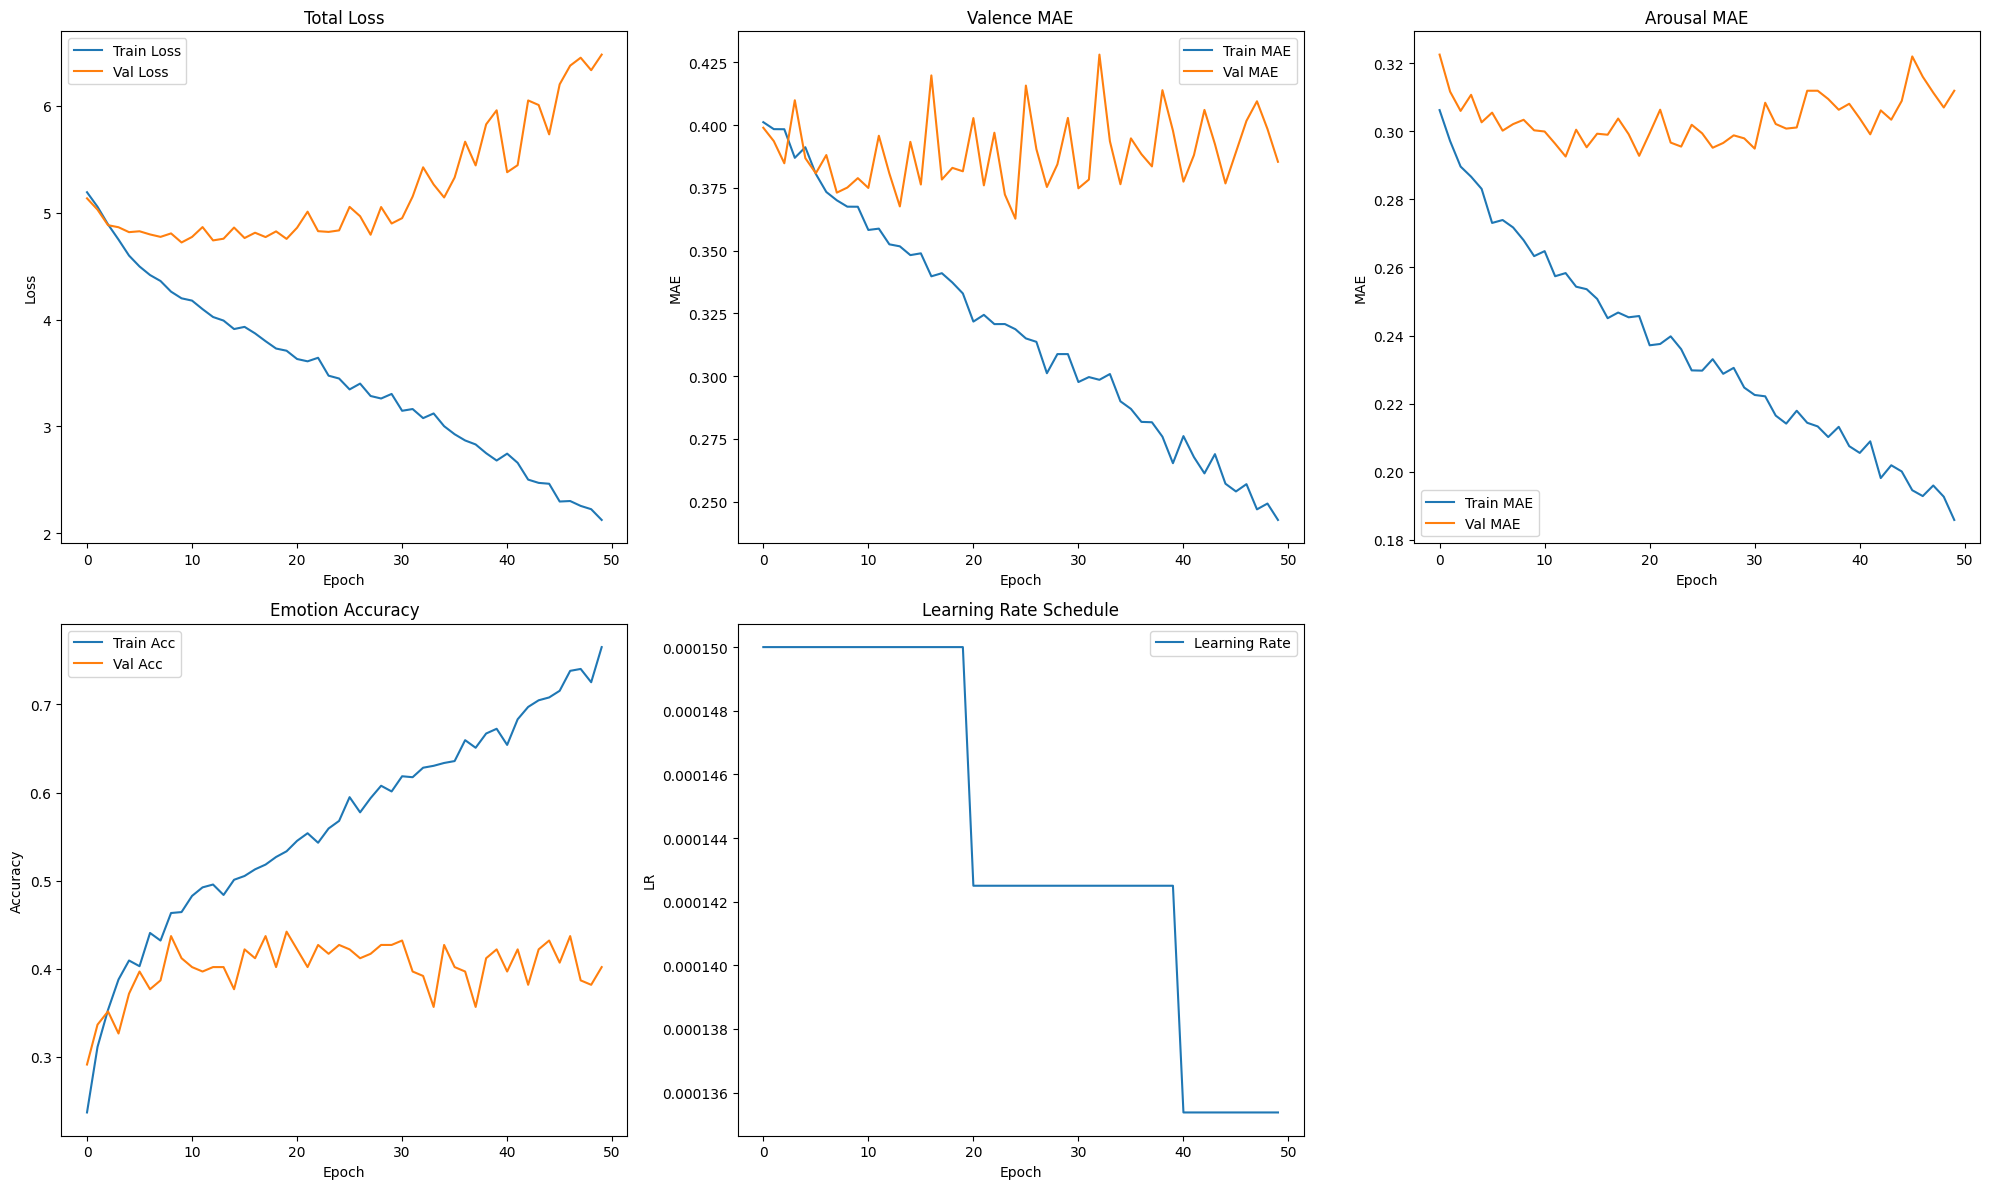


Emotion Classification Report:
              precision    recall  f1-score   support

       anger       0.57      0.39      0.46        41
     disgust       0.53      0.39      0.45        41
        fear       0.40      0.59      0.48        39
   happiness       0.42      0.32      0.36        41
     sadness       0.39      0.55      0.46        40

    accuracy                           0.45       202
   macro avg       0.46      0.45      0.44       202
weighted avg       0.47      0.45      0.44       202



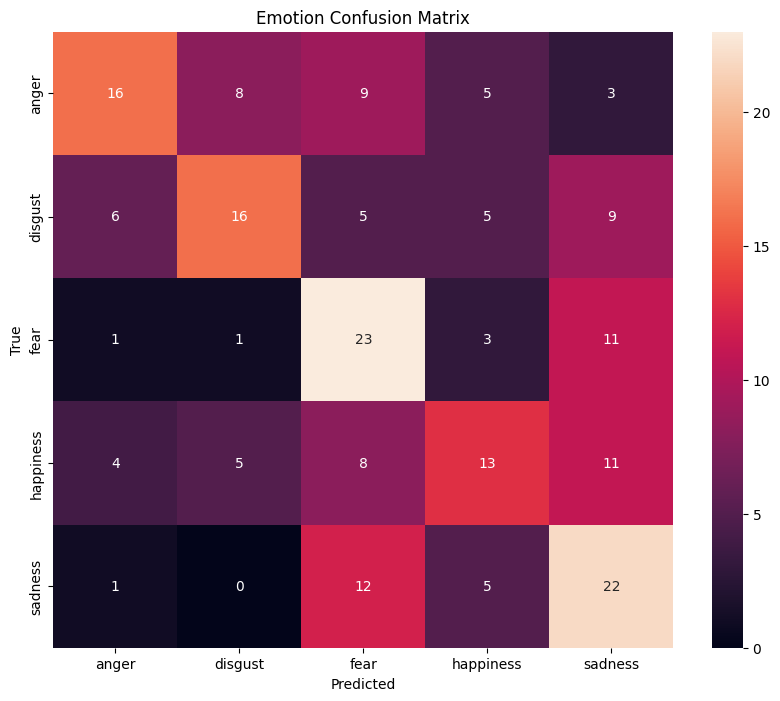

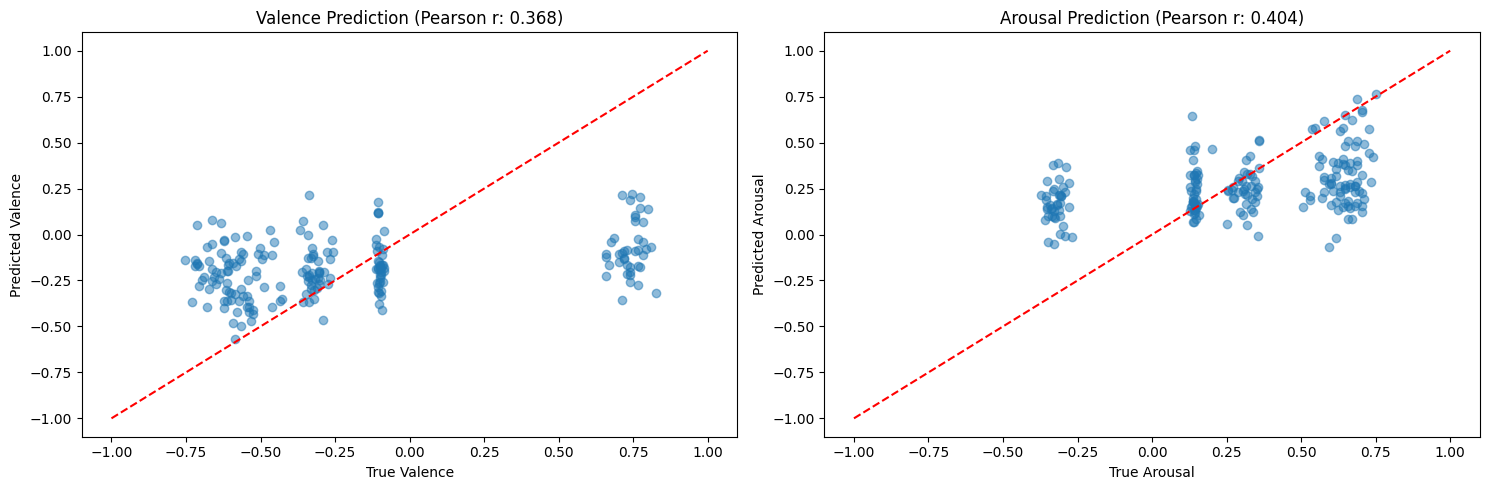

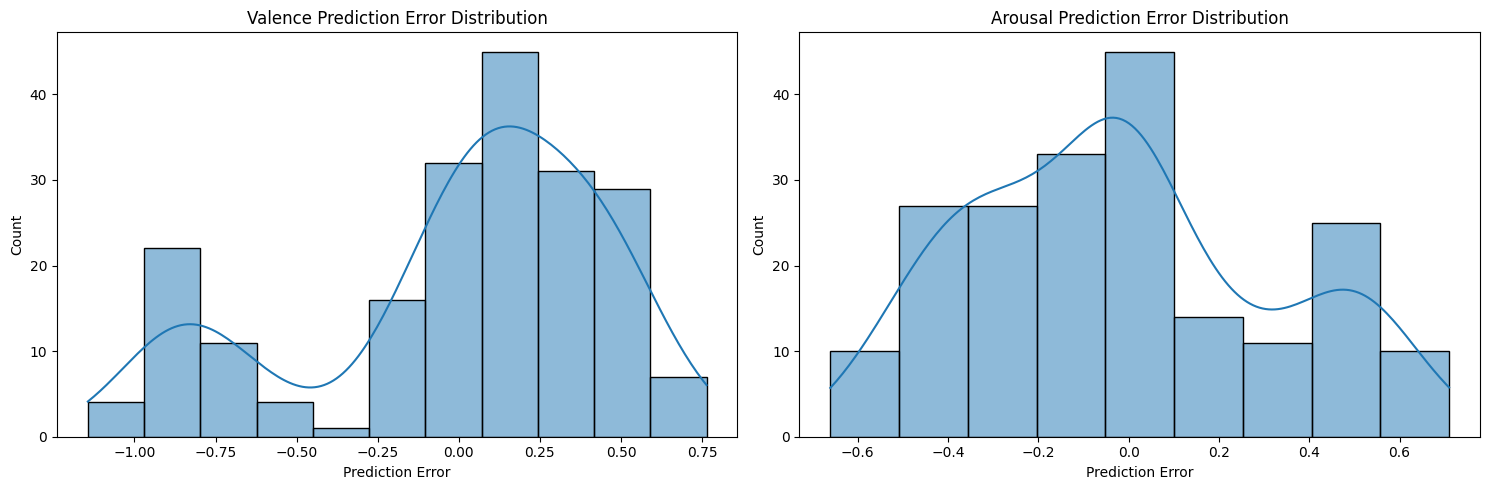

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Video: disgust_10141.mp4
True Emotion: disgust, Predicted: disgust
True Valence: -0.5984, Predicted: -0.4242
True Arousal: 0.3520, Predicted: 0.2620


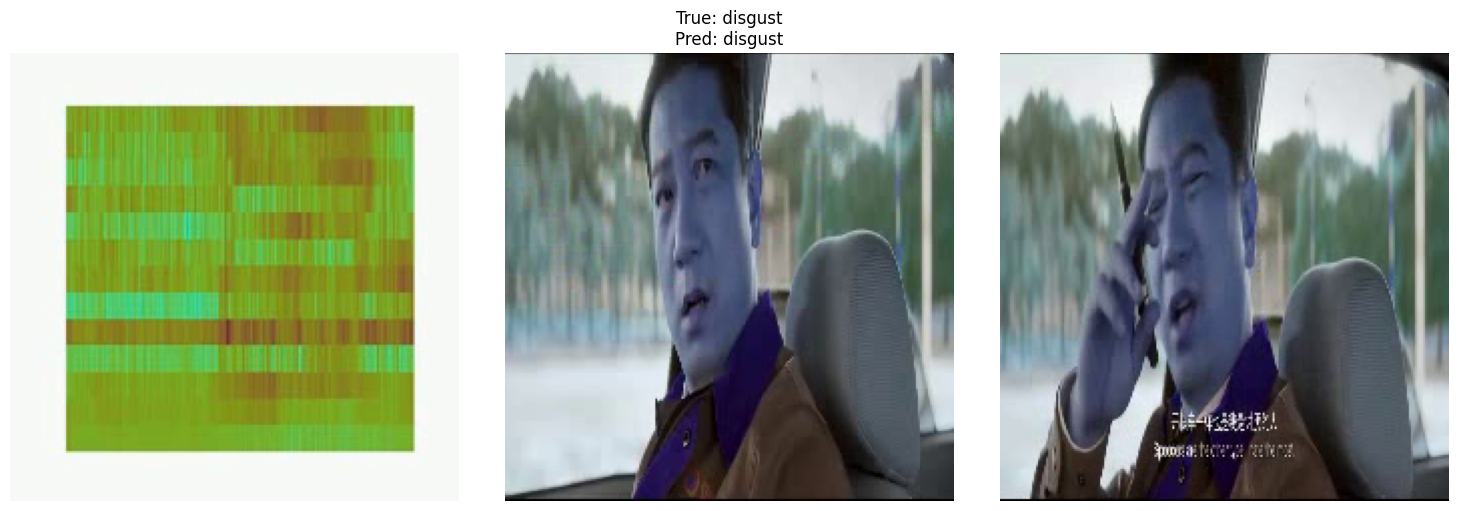

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Video: sadness_03019.mp4
True Emotion: sadness, Predicted: sadness
True Valence: -0.6885, Predicted: -0.2306
True Arousal: -0.3400, Predicted: 0.1395


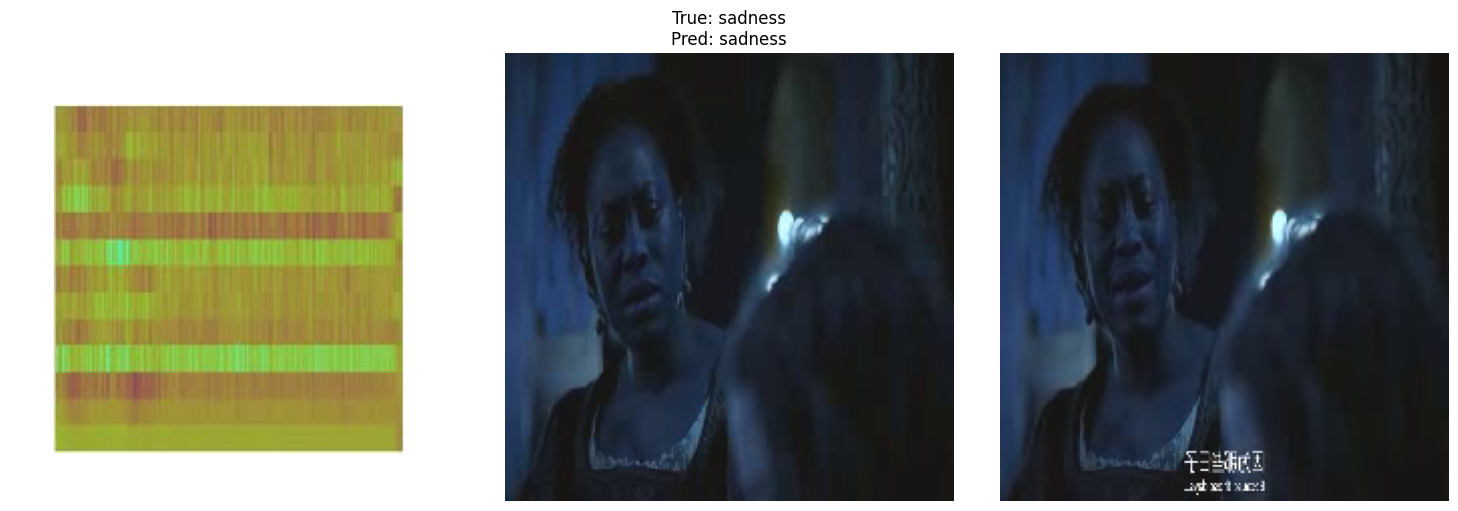

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Video: sadness_01740.mp4
True Emotion: sadness, Predicted: fear
True Valence: -0.5832, Predicted: -0.1713
True Arousal: -0.2880, Predicted: 0.3675


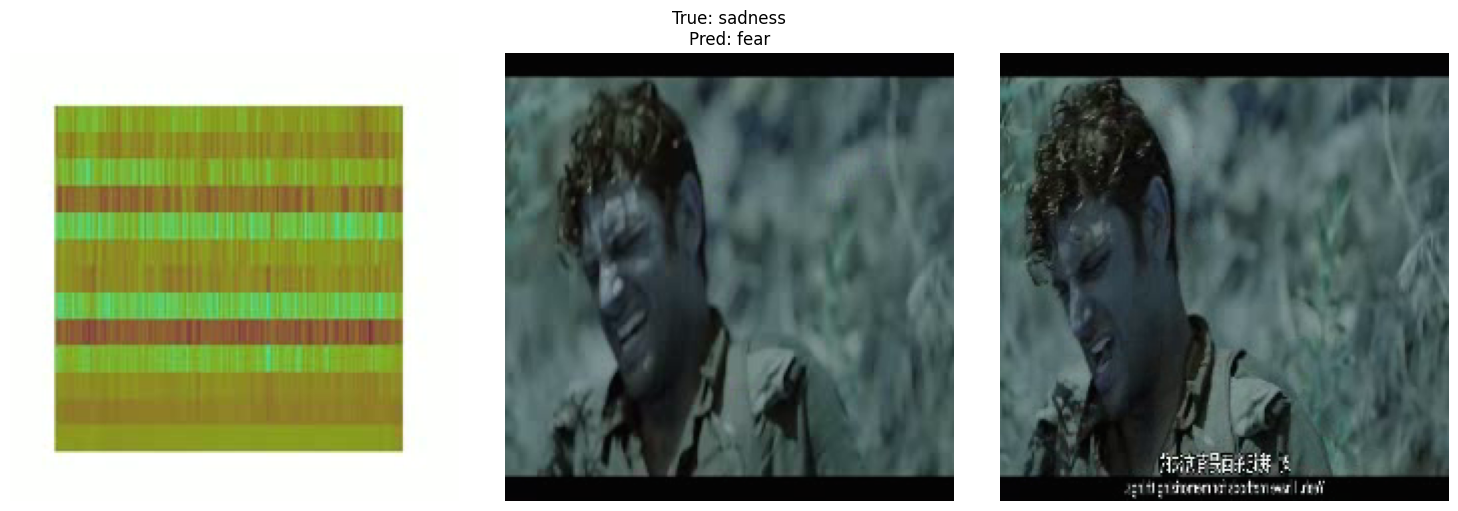

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import pearsonr

# 1. Plot training history
def plot_training_history(history):
    plt.figure(figsize=(20, 12))
    
    # Loss plots
    plt.subplot(2, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Valence MAE
    plt.subplot(2, 3, 2)
    plt.plot(history.history['valence_mae'], label='Train MAE')
    plt.plot(history.history['val_valence_mae'], label='Val MAE')
    plt.title('Valence MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    # Arousal MAE
    plt.subplot(2, 3, 3)
    plt.plot(history.history['arousal_mae'], label='Train MAE')
    plt.plot(history.history['val_arousal_mae'], label='Val MAE')
    plt.title('Arousal MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    # Emotion Accuracy
    plt.subplot(2, 3, 4)
    plt.plot(history.history['emotion_accuracy'], label='Train Acc')
    plt.plot(history.history['val_emotion_accuracy'], label='Val Acc')
    plt.title('Emotion Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Learning Rate
    plt.subplot(2, 3, 5)
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('LR')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def evaluate_test_set(model, test_ds, test_df, label_encoder):
    # Get all predictions
    y_true_emotion = []
    y_pred_emotion = []
    y_true_valence = []
    y_pred_valence = []
    y_true_arousal = []
    y_pred_arousal = []
    
    for batch in test_ds:
        videos, targets = batch
        preds = model.predict(videos, verbose=0)
        
        # Store predictions and true values
        y_pred_valence.extend(preds[0].flatten())
        y_true_valence.extend(targets['valence'].numpy().flatten())
        
        y_pred_arousal.extend(preds[1].flatten())
        y_true_arousal.extend(targets['arousal'].numpy().flatten())
        
        y_true_emotion.extend(targets['emotion'].numpy().flatten())
        y_pred_emotion.extend(np.argmax(preds[2], axis=1))
    
    # Convert to numpy arrays
    y_true_emotion = np.array(y_true_emotion)
    y_pred_emotion = np.array(y_pred_emotion)
    y_true_valence = np.array(y_true_valence)
    y_pred_valence = np.array(y_pred_valence)
    y_true_arousal = np.array(y_true_arousal)
    y_pred_arousal = np.array(y_pred_arousal)
    
    # 2.1 Emotion Classification Report and Confusion Matrix
    print("\nEmotion Classification Report:")
    print(classification_report(y_true_emotion, y_pred_emotion, 
                              target_names=label_encoder.classes_))
    
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true_emotion, y_pred_emotion)
    sns.heatmap(cm, annot=True, fmt='d', 
               xticklabels=label_encoder.classes_,
               yticklabels=label_encoder.classes_)
    plt.title('Emotion Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('emotion_confusion_matrix.png')
    plt.show()
    
    # 2.2 Valence-Arousal Correlation Plots
    plt.figure(figsize=(15, 5))
    
    # Valence plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_true_valence, y_pred_valence, alpha=0.5)
    plt.plot([-1, 1], [-1, 1], 'r--')
    plt.xlabel('True Valence')
    plt.ylabel('Predicted Valence')
    plt.title(f'Valence Prediction (Pearson r: {pearsonr(y_true_valence, y_pred_valence)[0]:.3f})')
    
    # Arousal plot
    plt.subplot(1, 2, 2)
    plt.scatter(y_true_arousal, y_pred_arousal, alpha=0.5)
    plt.plot([-1, 1], [-1, 1], 'r--')
    plt.xlabel('True Arousal')
    plt.ylabel('Predicted Arousal')
    plt.title(f'Arousal Prediction (Pearson r: {pearsonr(y_true_arousal, y_pred_arousal)[0]:.3f})')
    
    plt.tight_layout()
    plt.savefig('valence_arousal_predictions.png')
    plt.show()
    
    # 2.3 Error distributions
    plt.figure(figsize=(15, 5))
    
    # Valence error
    plt.subplot(1, 2, 1)
    valence_error = y_pred_valence - y_true_valence
    sns.histplot(valence_error, kde=True)
    plt.title('Valence Prediction Error Distribution')
    plt.xlabel('Prediction Error')
    
    # Arousal error
    plt.subplot(1, 2, 2)
    arousal_error = y_pred_arousal - y_true_arousal
    sns.histplot(arousal_error, kde=True)
    plt.title('Arousal Prediction Error Distribution')
    plt.xlabel('Prediction Error')
    
    plt.tight_layout()
    plt.savefig('error_distributions.png')
    plt.show()
    
    return {
        'emotion': {
            'true': y_true_emotion,
            'pred': y_pred_emotion
        },
        'valence': {
            'true': y_true_valence,
            'pred': y_pred_valence
        },
        'arousal': {
            'true': y_true_arousal,
            'pred': y_pred_arousal
        }
    }

# 3. Visualize sample predictions with frames
def visualize_sample_predictions(model, test_df, label_encoder, num_samples=5):
    samples = test_df.sample(num_samples)
    
    for idx, row in samples.iterrows():
        plt.figure(figsize=(15, 5))
        
        # Read and predict
        frames = read_video(tf.constant(row['video_path']))
        frames = tf.expand_dims(frames, 0)
        v_pred, a_pred, e_pred = model.predict(frames, verbose=0)
        
        # Get emotion prediction
        pred_emotion_idx = np.argmax(e_pred[0])
        pred_emotion = label_encoder.inverse_transform([pred_emotion_idx])[0]
        
        # Display first, middle, and last frame
        frame_indices = [0, num_frame//2, -1]
        for i, frame_idx in enumerate(frame_indices):
            plt.subplot(1, 3, i+1)
            plt.imshow(frames[0][frame_idx].numpy())
            plt.axis('off')
            if i == 1:
                plt.title(f"True: {row['dominant_emotion']}\nPred: {pred_emotion}")
        
        # Print metrics
        print(f"\nVideo: {os.path.basename(row['video_path'])}")
        print(f"True Emotion: {row['dominant_emotion']}, Predicted: {pred_emotion}")
        print(f"True Valence: {row['Adjusted Valence']:.4f}, Predicted: {v_pred[0][0]:.4f}")
        print(f"True Arousal: {row['Adjusted Arousal']:.4f}, Predicted: {a_pred[0][0]:.4f}")
        
        plt.tight_layout()
        plt.savefig(f'sample_prediction_{idx}.png')
        plt.show()

# 4. Main visualization function
def visualize_all_results(model, history, test_ds, test_df, label_encoder):
    # Plot training history
    plot_training_history(history)
    
    # Evaluate on test set
    test_results = evaluate_test_set(model, test_ds, test_df, label_encoder)
    
    # Visualize sample predictions
    visualize_sample_predictions(model, test_df, label_encoder, num_samples=3)
    
    return test_results

# After your training completes, call:
test_results = visualize_all_results(model, history, test_ds, test_df, label_encoder)

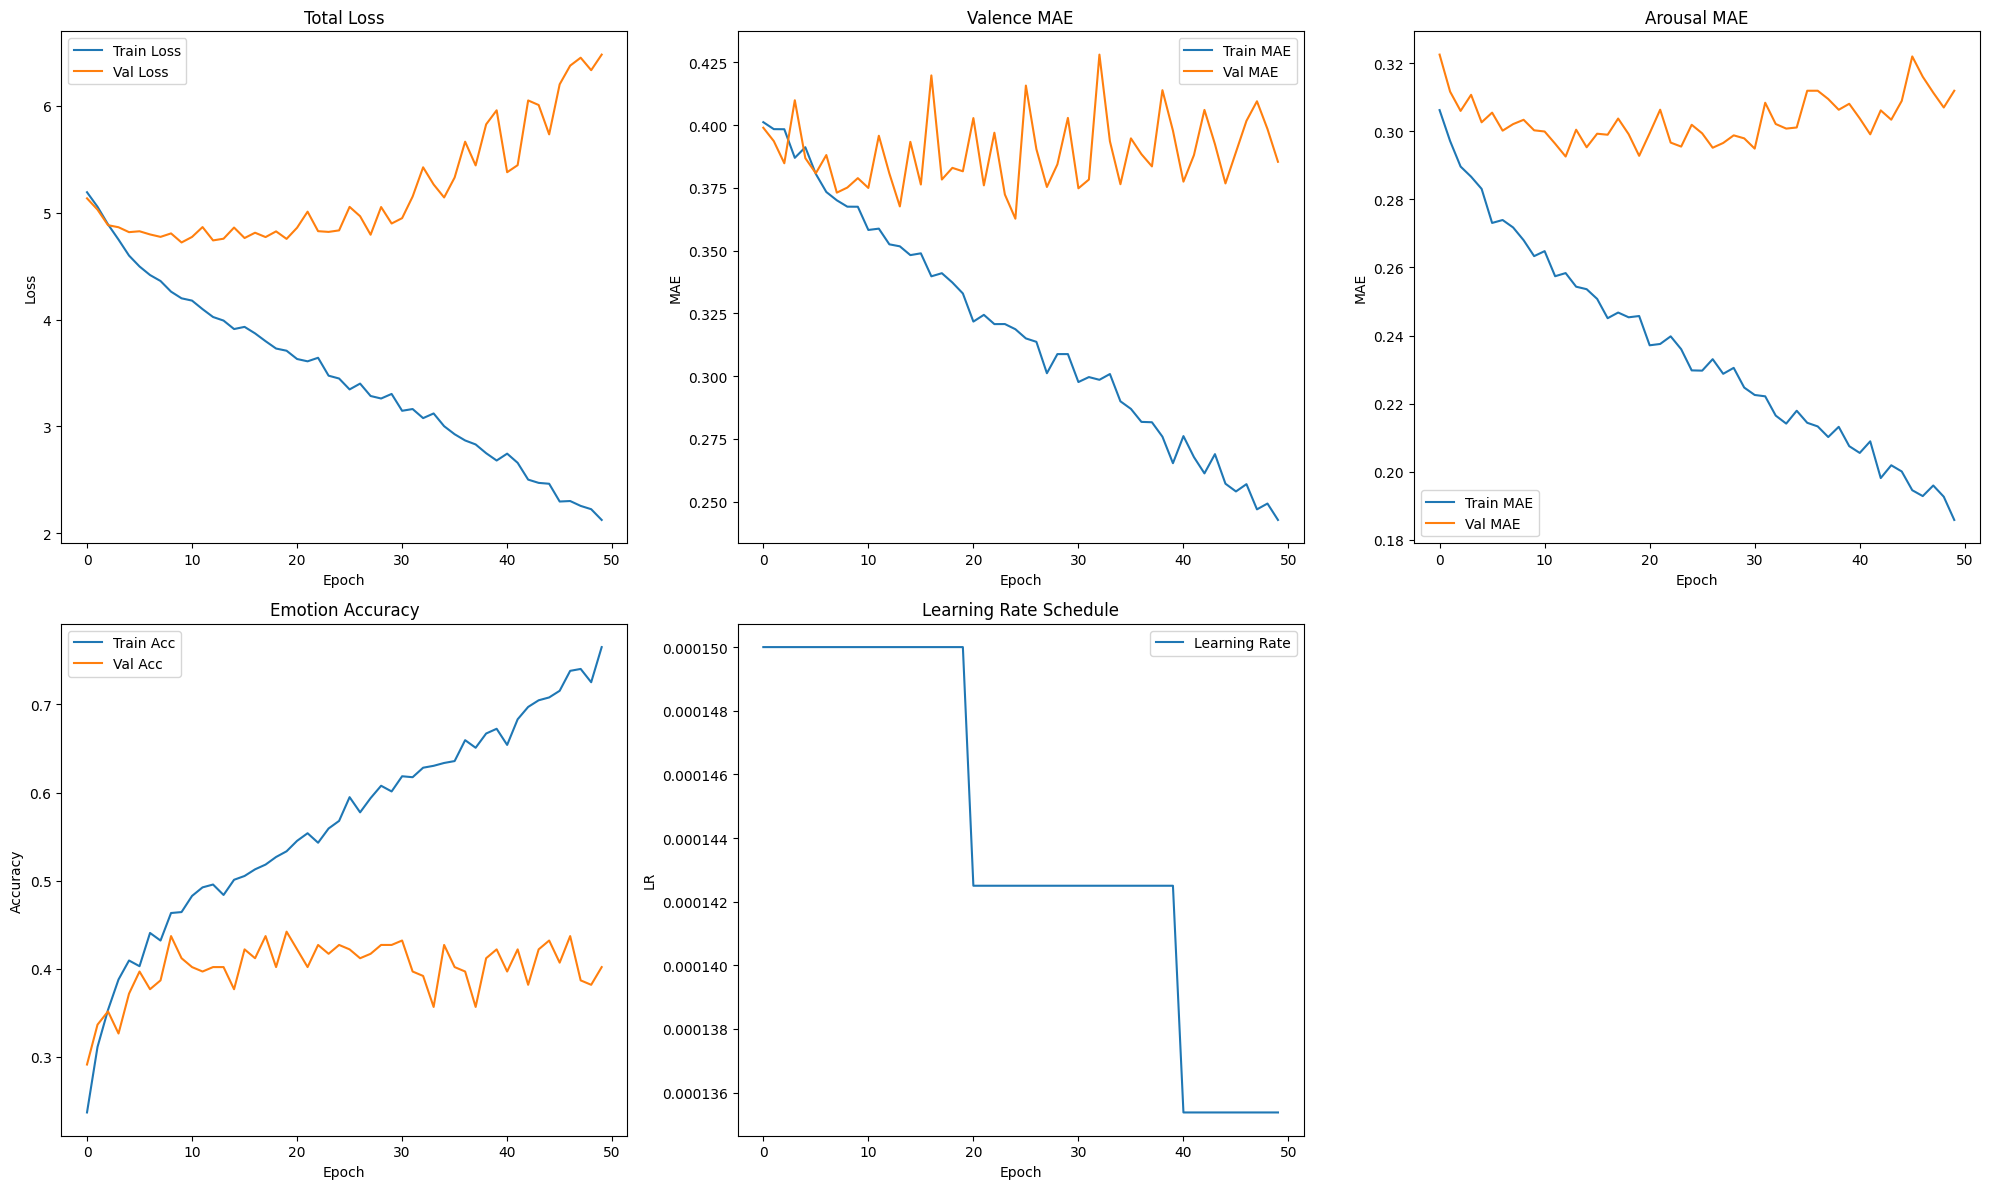


Emotion Classification Report:
              precision    recall  f1-score   support

       anger       0.57      0.39      0.46        41
     disgust       0.53      0.39      0.45        41
        fear       0.40      0.59      0.48        39
   happiness       0.42      0.32      0.36        41
     sadness       0.39      0.55      0.46        40

    accuracy                           0.45       202
   macro avg       0.46      0.45      0.44       202
weighted avg       0.47      0.45      0.44       202



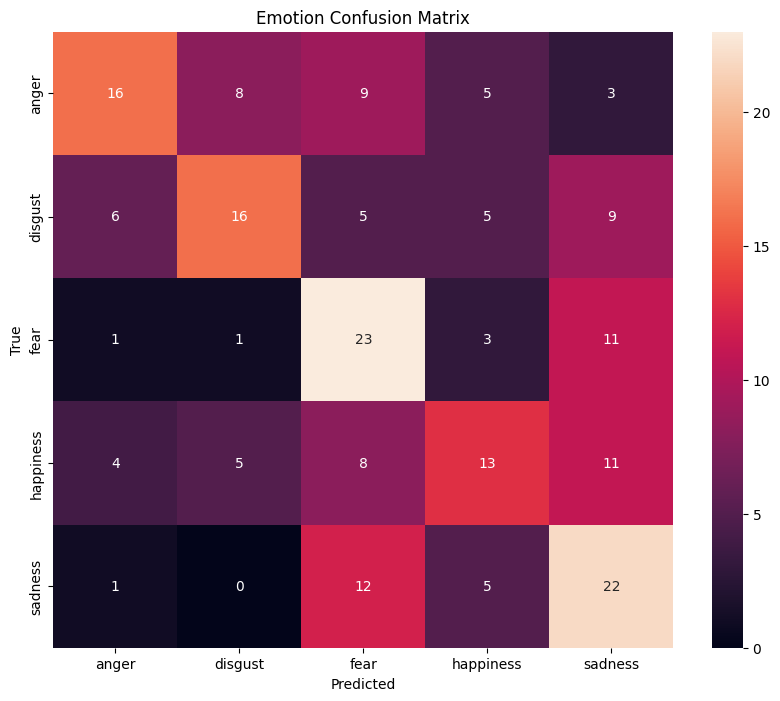

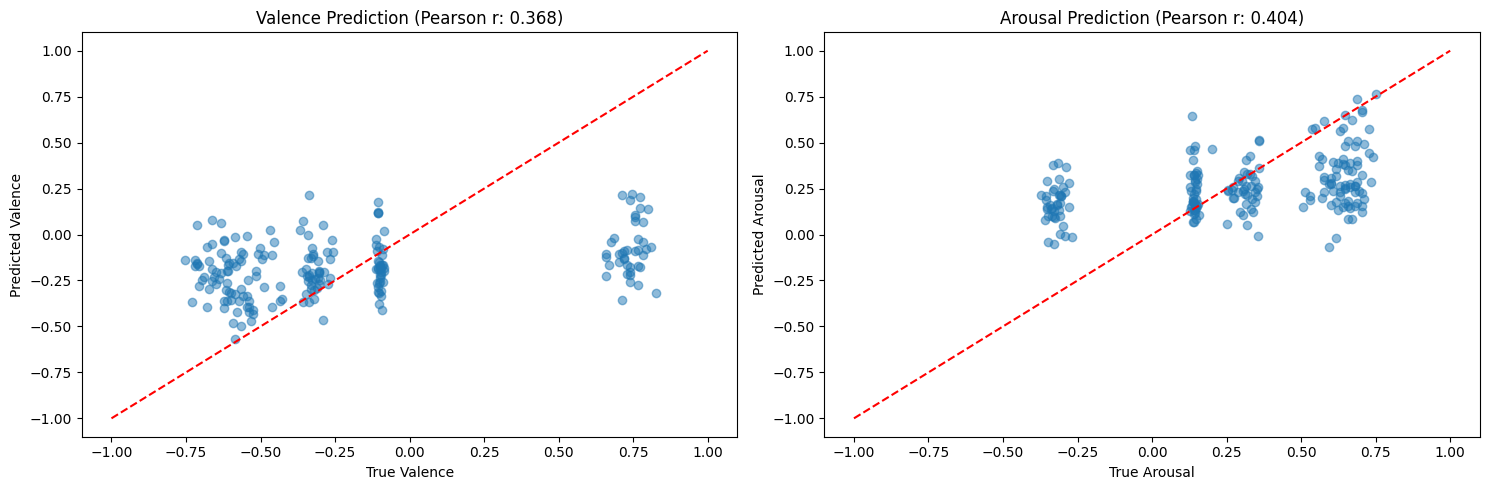

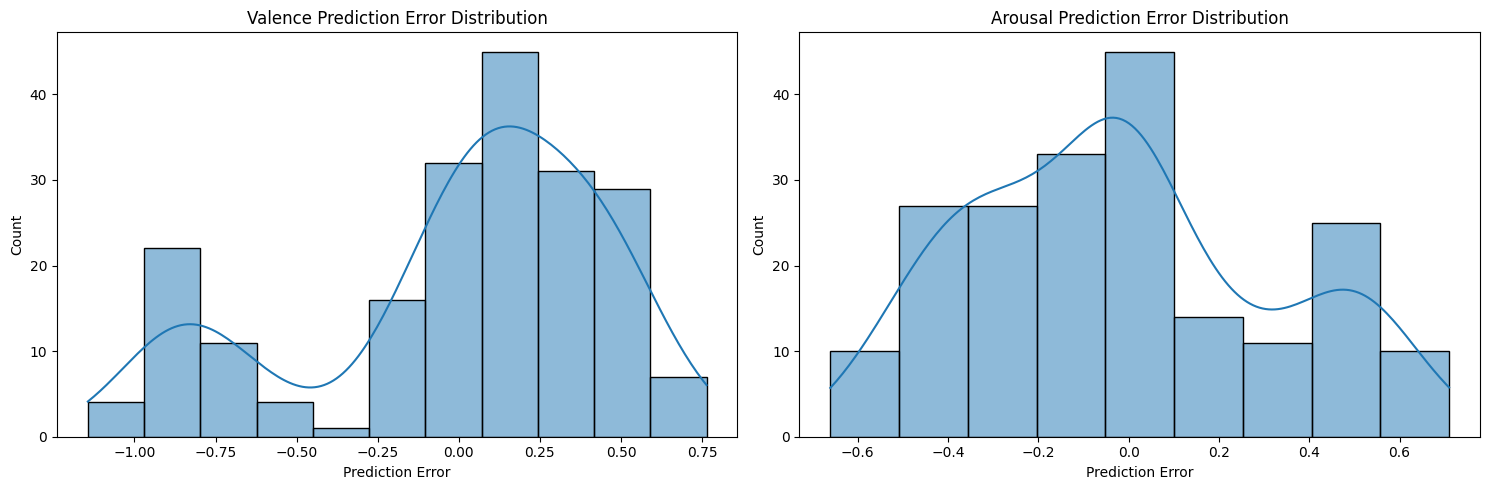

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Video: disgust_10141.mp4
True Emotion: disgust, Predicted: disgust
True Valence: -0.5984, Predicted: -0.4242
True Arousal: 0.3520, Predicted: 0.2620


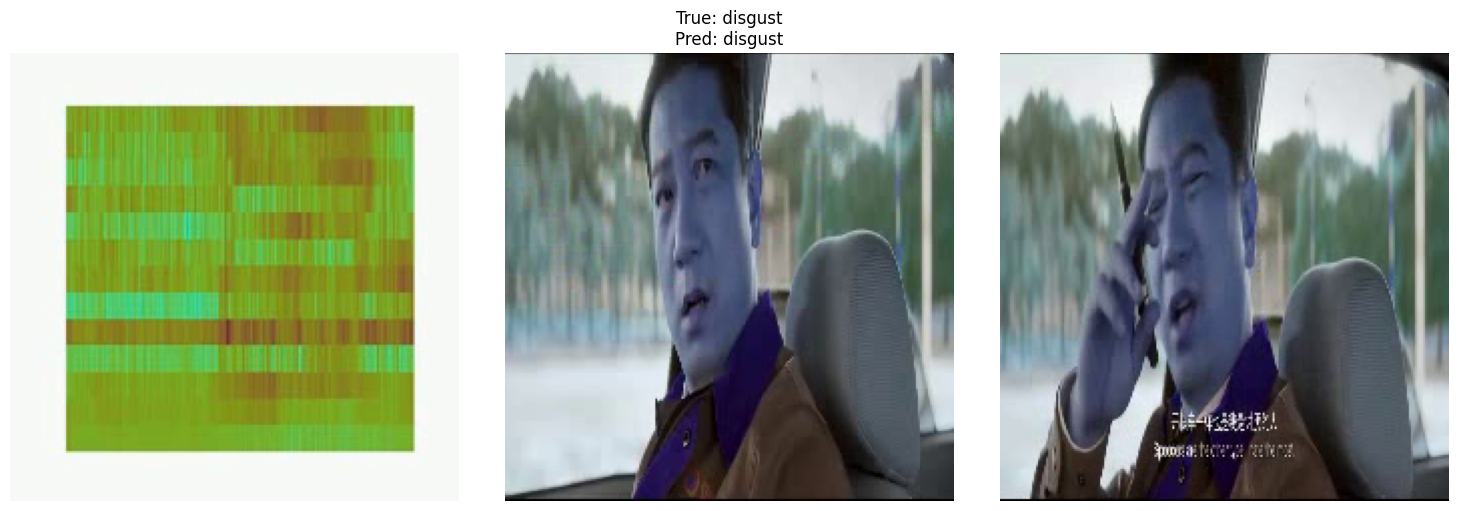

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Video: sadness_03019.mp4
True Emotion: sadness, Predicted: sadness
True Valence: -0.6885, Predicted: -0.2306
True Arousal: -0.3400, Predicted: 0.1395


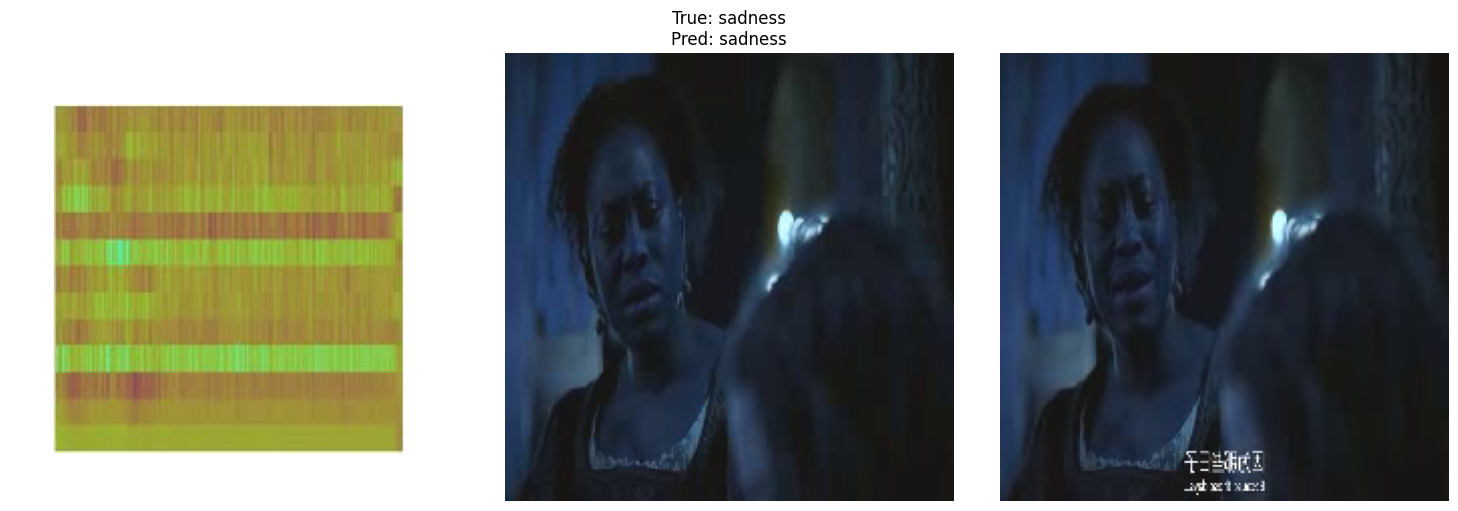

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Video: sadness_01740.mp4
True Emotion: sadness, Predicted: fear
True Valence: -0.5832, Predicted: -0.1713
True Arousal: -0.2880, Predicted: 0.3675


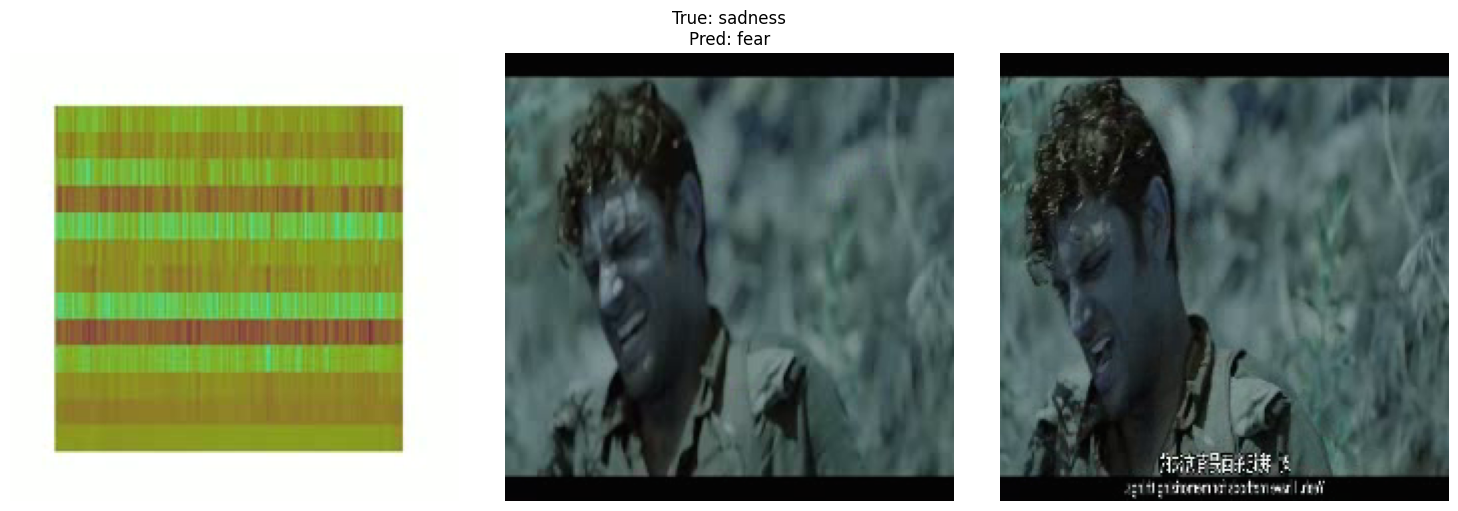

In [4]:
onmixed-data-last/WhatsApp Video 2025-06-20 at 13.00.03 (1).mp4onmixed-data-last/WhatsApp Video 2025-06-20 at 13.00.03 (1).mp4